<a href="https://colab.research.google.com/github/JRishabh1/Path-Planning-Algo/blob/test-1/vinay_testing_edge_algo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!git clone https://github.com/JRishabh1/Path-Planning-Algo

Cloning into 'Path-Planning-Algo'...
remote: Enumerating objects: 1024, done.
remote: Counting objects: 100% (374/374), done.
remote: Compressing objects: 100% (298/298), done.
remote: Total 1024 (delta 114), reused 324 (delta 73), pack-reused 650
Receiving objects: 100% (1024/1024), 130.82 MiB | 27.02 MiB/s, done.
Resolving deltas: 100% (131/131), done.


/content/Path-Planning-Algo


Iteration limit exceeded.
Drawing the result...
done with 
world1_50laplace_1branches_each_iter


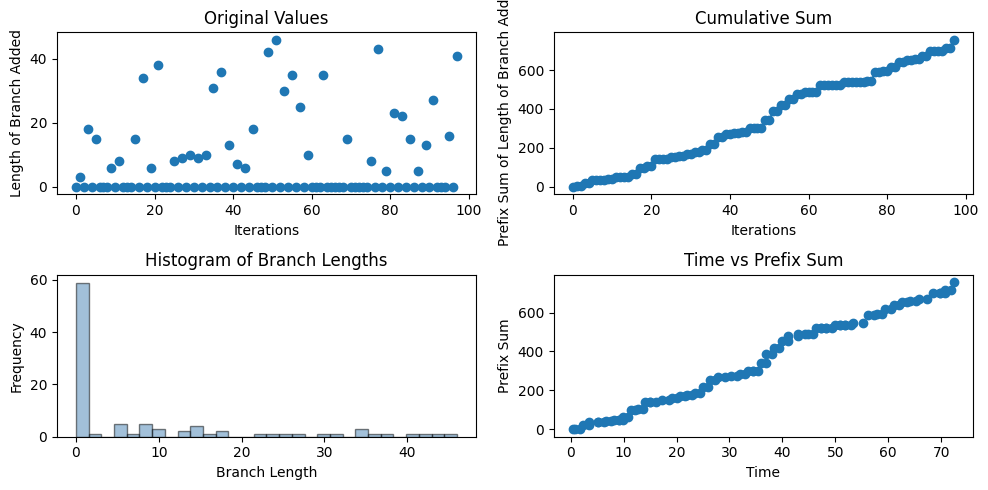

In [14]:
import numpy as np
import math
import random
from PIL import Image
import cv2
import imageio
import csv
import time
import pandas as pd
import matplotlib.pyplot as plt

class Node:
    """Class to store the RRT graph"""
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent_x = []
        self.parent_y = []


# Generate a random point along the edges
def random_point(start, height, length, potential_map, file_name, image, end, prob_of_choosing_start, show_every_attempted_point, show_expansion, start_time):
    # kernel = np.array([[1, 4, 1],
    #                    [4, -20, 4],
    #                    [1, 4, 1]])
    # new_grid = cv2.filter2D(potential_map, -1, kernel)
    # poss_points = []
    # for x in range(length - 1):
    #     for y in range(height - 1):
    #         if new_grid[y][x] != 0 and image[y][x][0] != 255 and potential_map[y][x] != 1:
    #             poss_points.append([y, x])
    # Step 1: Smooth the potential map

    # smoothed_map = cv2.GaussianBlur(subtract_one, (5, 5), 0)

    # Step 2: Apply the Laplacian


    # Step 3: Thresholding to identify edges
    # threshold_value = 0.00001#0.00001#0.0001  # This is a parameter you might need to adjust
    # _, edges = cv2.threshold(np.abs(laplacian), threshold_value, 1, cv2.THRESH_BINARY)

    # Step 4: Find Edge Points
    # edge_points = np.argwhere(edges > 0)
    potential_map_as_image = np.copy(potential_map)
    for x in range(0, len(potential_map_as_image)):
        for y in range(0, len(potential_map_as_image[x])):
            if(potential_map_as_image[x][y] == 1 or potential_map_as_image[x][y] < 0.99 ):
                potential_map_as_image[x][y] = 0
            else:
                potential_map_as_image[x][y] = 1# 255  - int(potential_map[x][y]*225)
    laplacian = cv2.Laplacian(potential_map_as_image, cv2.CV_64F)
    _, edges = cv2.threshold(np.abs(laplacian), 0, 1, cv2.THRESH_BINARY)
    # _, edges = cv2.threshold(np.abs(laplacian), 30.1, 30.2, cv2.THRESH_BINARY)
    edge_points = np.argwhere(edges > 0)
    # cv2.imshow('Edges', edges)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    # print(len(edge_points))
    if(len(edge_points) == 0):
        return (-1, -1, potential_map)

    len_per_iter.append(0)


    time_per_iter.append(time.time() - start_time)


    [new_y, new_x] = edge_points[random.randint(0, len(edge_points)-1)]
    if(show_every_attempted_point and image[new_y][new_x][0] == 255 and new_y < height - 2 and new_x < length - 2):
        im = Image.open(file_name)
        result = im.copy() # result image
        draw_result(image, result, start, end, node_list, potential_map, show_expansion)#draw_result(image, result, start, end, parent_x_array, parent_y_array)
        for x in range(new_x - 3, new_x + 3):
            for y in range(new_y - 3, new_y + 3):
                if(0 < x and x < length - 1 and 0 < y and y < height - 1):
                    result.putpixel((x, y), (0, 0, 255))
        result_images.append(result)
    # new_x = random.randint(0, length - 1)#start[1]
    # new_y = random.randint(0, height - 1)#start[0]
    # # if(random.random() < prob_of_choosing_start): # > 1 -
    # #     new_x = start[1]
    # #     new_y = start[0]
    # if(show_every_attempted_point and image[new_y][new_x][0] == 255):
    #     im = Image.open(file_name)
    #     result = im.copy() # result image
    #     draw_result(image, result, start, end, node_list, potential_map, show_expansion)#draw_result(image, result, start, end, parent_x_array, parent_y_array)
    #     for x in range(new_x - 3, new_x + 3):
    #         for y in range(new_y - 3, new_y + 3):
    #             if(0 < x and x < length - 1 and 0 < y and y < height - 1):
    #                 result.putpixel((x, y), (0, 0, 255))
    #     result_images.append(result)

    # while potential_map[new_y][new_x] == 1: #or needToFindNew
    #     len_per_iter.append(0) #this random point added 0 to our tree
    #     time_per_iter.append(time.time() - start_time)


    #     new_x = random.randint(0, length - 1)
    #     new_y = random.randint(0, height - 1)
    #     if(show_every_attempted_point and image[new_y][new_x][0] == 255):
    #         im = Image.open(file_name)
    #         result = im.copy() # result image
    #         draw_result(image, result, start, end, node_list, potential_map, show_expansion)#draw_result(image, result, start, end, parent_x_array, parent_y_array)
    #         for x in range(new_x - 3, new_x + 3):
    #             for y in range(new_y - 3, new_y + 3):
    #                 if(0 < x and x < length - 1 and 0 < y and y < height - 1):
    #                     result.putpixel((x, y), (0, 0, 255))
    #         result_images.append(result)
    return (new_x, new_y, potential_map)

def LaPlace_average(potential_map, kernel, height, length, boundary_x, boundary_y, end, node_list):
    potential_map = cv2.filter2D(potential_map, -1, kernel)

    # Reset boundary points
    potential_map[end[1]][end[0]] = 0 # Goal
    for node in node_list:
        potential_map[min(int(node.y), height - 1)][min(int(node.x), length - 1)] = 0
    for b in range(len(boundary_y)):
        potential_map[boundary_y[b]][boundary_x[b]] = 1
    for y in range(height):
        potential_map[y][0] = 1
        potential_map[y][length-1] = 1
    for x in range(length):
        potential_map[0][x] = 1
        potential_map[height-1][x] = 1
    return potential_map

# RRT Algorithm
def RRT(image, start, end, iterations, step_size, file_name, prob_of_choosing_start, la_place_at_start, la_place_each_time, show_every_attempted_point, show_expansion, branches_before_each_laplace):
    height = len(image)
    length = len(image[0])

    node_list.append(Node(end[0], end[1]))
    node_list[0].parent_x.append(end[0])
    node_list[0].parent_y.append(end[1])

    total_iter = 0
    i = 1
    pathFound = False

    potential_map = np.ones((height, length))
    potential_map[end[1]][end[0]] = 0
    boundary_x = []
    boundary_y = []
    for y in range(height):
        for x in range(length):
            if(image[y][x][0] == 0):
                boundary_x.append(x)
                boundary_y.append(y)

    # Kernel for Laplace equation
    kernel = np.array([[0.00, 0.25, 0.00],
                       [0.25, 0.00, 0.25],
                       [0.00, 0.25, 0.00]])

    start_time = time.time()
    for _ in range(la_place_at_start):
        potential_map = LaPlace_average(potential_map, kernel, height, length, boundary_x, boundary_y, end, node_list)
    while pathFound == False:
        total_iter = total_iter + 1

        if(total_iter == iterations):
            print("Iteration limit exceeded.")
            return node_list

        # Get random point
        for _ in range(branches_before_each_laplace):
            new_x, new_y, potential_map = random_point(start, height, length, potential_map, file_name, image, end, prob_of_choosing_start, show_every_attempted_point, show_expansion, start_time)
            if (new_x == -1):
                return node_list


            new_node_list = try_grad_descent(potential_map, step_size, new_x, new_y, node_list)
            i = i + len(new_node_list)
            node_list.extend(new_node_list)
            len_per_iter.append(len(new_node_list))
            time_per_iter.append(time.time() - start_time)
            # HERE - Drawing image step by step
            im = Image.open(file_name)
            result = im.copy() # result image
            draw_result(image, result, start, end, node_list, potential_map, show_expansion)
            for x in range(new_x - 3, new_x + 3):
                for y in range(new_y - 3, new_y + 3):
                    if(0 < x and x < length - 1 and 0 < y and y < height - 1):
                        result.putpixel((x, y), (0, 255, 255))
            result_images.append(result)
            #TO HERE

            # if len(new_node_list) != 0 and int(new_x) == start[0] and int(new_y) == start[1]:
            #     pathFound = True

        for _ in range(la_place_each_time):
            potential_map = LaPlace_average(potential_map, kernel, height, length, boundary_x, boundary_y, end, node_list)
    return node_list

def try_grad_descent(potential_map, step_size, new_x, new_y, node_list):
    poser = new_y
    posec = new_x
    toAppend = Node(int(posec), int(poser))

    limit = 0
    new_node_list = []
    new_node_list.append(toAppend)
    while True:
        if limit > 1000:
            # print("Couldn't find - Stuck :(") - if there is a meaningful gradient from the first point, should never hit this
            return []

        # gradr = potential_map[round(poser+1)][round(posec)] - potential_map[round(poser-1)][round(posec)]
        # gradc = potential_map[round(poser)][round(posec+1)] - potential_map[round(poser)][round(posec-1)]
        if 0 < poser < potential_map.shape[0]-1 and 0 < posec < potential_map.shape[1]-1:
            gradr = potential_map[int(poser+1)][int(posec)] - potential_map[int(poser-1)][int(posec)]
            gradc = potential_map[int(poser)][int(posec+1)] - potential_map[int(poser)][int(posec-1)]
        else:
            # Avoid calculations that would go out of bounds
            return []
        maggrad = math.sqrt(gradr**2 + gradc**2)

        if(maggrad != 0):
            a = step_size/maggrad
            poser = poser-a*gradr
            posec = posec-a*gradc
        toAppend = Node(int(posec), int(poser))
        new_node_list.append(toAppend)
        limit = limit + 1


        for node in node_list:
            if(node.y-step_size-1 < poser and poser < node.y+step_size+1 and node.x-step_size-1 < posec and posec < node.x+step_size+1):
                return new_node_list



def draw_result(image, result, start, end, node_list, potential_map, show_expansion):
    height = len(image)
    length = len(image[0])

    if show_expansion:
        for x in range(0, length):
            for y in range(0, height):
                if potential_map[y][x] == 1:
                    toPut =  0
                    result.putpixel((x, y), (toPut, toPut, toPut))
                else:
                    toPut = 250 - int(potential_map[y][x]*225)#200#150
                    result.putpixel((x, y), (toPut, toPut, toPut))

    # Draw all of the nodes in the RRT
    for node in node_list:
        #print(node)
        round_x = math.floor(node.x)
        round_y = math.floor(node.y)
        for x in range(round_x - 1, round_x + 1):
            for y in range(round_y - 1, round_y + 1):
                if(0 < x and x < length - 1 and 0 < y and y < height - 1):
                    result.putpixel((x, y), (255, 0, 0))

    # Draw the start point
    for x in range(start[0] - 3, start[0] + 3):
        for y in range(start[1] - 3, start[1] + 3):
            if(0 < x and x < length - 1 and 0 < y and y < height - 1):
                result.putpixel((x, y), (0, 255, 0))

    # Draw the end point
    for x in range(end[0] - 3, end[0] + 3):
        for y in range(end[1] - 3, end[1] + 3):
            if(0 < x and x < length - 1 and 0 < y and y < height - 1):
                result.putpixel((x, y), (0, 0, 255))



def running_hybridization(image, start, end, iterations, step_size, la_place_at_start, la_place_each_time, prob_of_choosing_start, show_every_attempted_point, show_expansion, output_path, fps, branches_before_each_laplace):
    file_name = image

    # Get image and convert to 2D array
    im = Image.open(image)
    image = np.asarray(im)

    start_comma = start.index(',')
    end_comma = end.index(',')

    start_first_number = int(start[1:start_comma])
    start_second_number = int(start[start_comma+2:len(start)-1])
    end_first_number = int(end[1:end_comma])
    end_second_number = int(end[end_comma+2:len(end)-1])

    start = (start_first_number, start_second_number)
    end = (end_first_number, end_second_number)
    node_list = RRT(image, start, end, iterations, step_size, file_name, prob_of_choosing_start, la_place_at_start, la_place_each_time, show_every_attempted_point, show_expansion, branches_before_each_laplace)

    print("Drawing the result...")
    result = im.copy()
    height = len(image)
    length = len(image[0])
    draw_result(image, result, start, end, node_list, potential_map=np.zeros((height, length)), show_expansion=False)
    im = Image.open(file_name)
    result_images.append(result)
    result.show()

    writer = imageio.get_writer(output_path + ".mp4", fps=fps)

    for image_filename in result_images:
        writer.append_data(np.array(image_filename))

    writer.close()

    with open(output_path + '.csv', 'w', newline='') as file:
        csv_writer = csv.writer(file)
        csv_writer.writerow(len_per_iter)
        csv_writer.writerow(time_per_iter)


def csv_to_graph(file):
    data = pd.read_csv(file + ".csv", header=None)

    values = data.iloc[0].values
    time = data.iloc[1].values

    # Compute prefix sum
    prefix_sum = values.cumsum()

    # Plot of each point
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.plot(values, marker='o', linestyle=' ')
    plt.title('Original Values')
    plt.xlabel('Iterations')
    plt.ylabel('Length of Branch Added')

    # Plot using prefix sum
    plt.subplot(2, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.plot(prefix_sum, marker='o', linestyle='-')
    plt.title('Cumulative Sum')
    plt.xlabel('Iterations')
    plt.ylabel('Prefix Sum of Length of Branch Added')

    plt.subplot(2, 2, 3)
    plt.hist(values, bins=30, alpha=0.5, color='steelblue', edgecolor='black')
    plt.title('Histogram of Branch Lengths')

    plt.xlabel('Branch Length')
    plt.ylabel('Frequency')

    plt.subplot(2, 2, 4)
    plt.plot(time, prefix_sum, marker='o', linestyle='')

    # Customize the plot
    plt.title('Time vs Prefix Sum')
    plt.xlabel('Time')
    plt.ylabel('Prefix Sum')

    plt.tight_layout()
    plt.savefig(file + '.png', dpi=300, bbox_inches='tight')


# TESTS BEING RUN:

images_to_test = ["world1"]
start = "(1, 1)"
end = "(650, 350)"
iterations = 50
step_size = 3
laplace_iters_to_test = [50]
branches_before_each_laplace = [1]
prob_of_choosing_start = 0
show_every_attempted_point = "y"
show_expansion = "y"
fps = 20

for i in range(len(images_to_test)):
    image = images_to_test[i]
    for j in range(len(laplace_iters_to_test)):
        for k in range(len(branches_before_each_laplace)):
            la_place_at_start = laplace_iters_to_test[j]
            la_place_each_time = laplace_iters_to_test[j]
            branch_each_time = branches_before_each_laplace[k]
            len_per_iter = []
            time_per_iter = []
            node_list = []
            result_images = []
            output_path = str(image) + "_" + str(la_place_each_time) + "laplace_" + str(branch_each_time) + "branches_each_iter"
            running_hybridization(image + ".png", start, end, iterations, step_size, la_place_at_start, la_place_each_time, prob_of_choosing_start, show_every_attempted_point, show_expansion, output_path, fps, branch_each_time)
            csv_to_graph(output_path)
            print("done with ")
            print(output_path)